# How to rediscover the Higgs boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

The idea is that you add extra cuts to increase the ratio of signal ($H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$) to background ($Z, t\bar{t}, ZZ \rightarrow \ell\ell\ell\ell$)

First, try to reduce the amount of $Z$ and $t\bar{t}$ background, since these are quite different to the signal.

Then, try to reduce the amount of $ZZ \rightarrow \ell\ell\ell\ell$, whilst keeping $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ signal

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

<CENTER><img src="HZZ_feynman.pdf" style="width:40%"></CENTER>

## First time setup
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close jupyter and re-open on the same computer, you won't need to run this first cell again.

If you re-open on binder, you will need to run this cell again.

If you run into a problem of "uproot not being available", Kernel -> Restart & Run All

In [1]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib --user

Traceback (most recent call last):
  File "/Users/stan/anaconda3/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/stan/anaconda3/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/stan/.local/lib/python3.7/site-packages/pip/__main__.py", line 19, in <module>
    sys.exit(_main())
  File "/Users/stan/.local/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/Users/stan/.local/lib/python3.7/site-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/Users/stan/anaconda3/anaconda3/lib/python3.7/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._boo

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [2]:
import uproot
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
from lmfit.models import PolynomialModel, GaussianModel
from scipy.stats import norm
import infofile
from scipy.interpolate import interp1d, barycentric_interpolate

from scipy.optimize import curve_fit


In [3]:
lumi = 10064.3
                                                                                                                                  
tuple_path = "Photon_Input/"     

stack_order = ['data',r'$gg \rightarrow H\rightarrow yy$',r'$tt \rightarrow H\rightarrow yy$',r'$VBF \rightarrow H\rightarrow yy$',r'$W \rightarrow H\rightarrow yy$',r'$Z \rightarrow H\rightarrow yy$']

In [4]:
#samples = {
#
#    'data': {
#        'list' : ['data_A','data_B','data_C','data_D']
#    },
#    
#    r'$H \rightarrow yy$' : {
#        'list' : ['ggHyy','ttHyy','VBFHyy','WHyy','ZHyy'],
#        'color' : "#f90000"
#    }
#    
#}

samples = {

    'data': {
        'list' : ['data_C']
    },
    
    r'$gg \rightarrow H\rightarrow yy$' : {
        'list' : ['ggHyy'],
        'color' : "#00cdff"
    },
    
    r'$tt \rightarrow H\rightarrow yy$' : {
        'list' : ['ttHyy'],
        'color' : "#FF8000"
    },
    
    r'$VBF \rightarrow H\rightarrow yy$' : {
        'list' : ['VBFHyy'],
        'color' : "#15EF3A"
    },
    
    r'$W \rightarrow H\rightarrow yy$' : {
        'list' : ['WHyy'],
        'color' : "#ff0000"
    },
    
    r'$Z \rightarrow H\rightarrow yy$' : {
        'list' : ['ZHyy'],
        'color' : "#8700da"
    }
}

dic={'ggHyy':'ggH125','ttHyy':'ttH125','VBFHyy':'VBFH125','WHyy':'WpH125J_Wincl','ZHyy':'ZH125J_Zincl'}

# ^ using a dictionary to correct for the names of the MC files, as they are differently named in the infofile module.

for s in samples:
    for val in samples[s]['list']:
        if s == 'data':
            None
        else: 
            prefix='MC/mc_'
            print(prefix+str(infofile.infos[val]['DSID'])+'.'+dic[val])

MC/mc_343981.ggH125
MC/mc_341081.ttH125
MC/mc_345041.VBFH125
MC/mc_345318.WpH125J_Wincl
MC/mc_345319.ZH125J_Zincl


In [5]:
def get_data_from_files(cutval=0):

    data = {}
    
    for s in samples:
        print(s+':')
        frames = []
        for val in samples[s]['list']:
            prefix = "MC/mc_"
            if s == 'data':
                prefix = "data/"
                fileString = tuple_path+prefix+val+".GamGam.root"
            else: 
                
                prefix += str(infofile.infos[val]["DSID"])+"."           #Changes made over here regarding the names of the files
                fileString = tuple_path+prefix+dic[val]+"_gamgam.GamGam.root"
            print(fileString)
            f = glob.glob(fileString,recursive=False)[0]
            if f != "":
                temp = read_file(f,val,cutval)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)

    return data

In [6]:
def myy_window(myy):
    return 100 < myy < 160

In [7]:
def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_LepTRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

In [8]:
def get_xsec_weight(totalWeight,sample):
    info = infofile.infos[sample]
    weight = (lumi*info["xsec"])/(info["sumw"]*info["red_eff"])
    weight *= totalWeight
    return weight

In [9]:
def plot_databar(data):

    bins = [100 + x*2 for x in range(31) ]
    data_x = [101 + x*2 for x in range(30) ]

    data_myy = []
    data_myy_errors = []

    mc_myy = []
    mc_weights = []
    mc_colors = []
    mc_labels = []
    mc_in_myy_window = [] # list for numbers of MC events with 100 < myy < 160 GeV

    for s in stack_order:
        if s == "data":
            data_myy,_ = np.histogram(data[s].myy.values, bins=bins)
            data_myy_errors = np.sqrt(data_myy)
        else:
            mc_labels.append(s)
            mc_myy.append(data[s].myy.values)
            mc_colors.append(samples[s]['color'])
            mc_weights.append(data[s].totalWeight.values)
            mc_in_myy_window.append([data[s].totalWeight.values[myy_iter] for myy_iter in range(len(data[s].myy.values)) if 100 < data[s].myy.values[myy_iter] < 160])
    
    HYY_in_myy_window = sum(mc_in_myy_window[2]) # number signal MC events with 100 < myy < 160 GeV
    background_in_myy_window = sum(mc_in_myy_window[0]+mc_in_myy_window[1]) # number background MC events with 100 < myy < 160 GeV
    SoversqrtB = HYY_in_myy_window/math.sqrt(background_in_myy_window) # calculate significance
    print('Signal/sqrt(Background) for 100<m(yy)<160 '+str(SoversqrtB))

    top = np.amax(data_myy)+math.sqrt(np.amax(data_myy))

    plt.figure()
    plt.hist(mc_myy,bins=bins,weights=mc_weights,stacked=True,color=mc_colors, label=mc_labels)
    plt.errorbar( x=data_x, y=data_myy, yerr=data_myy_errors, fmt='ko', label='Data')

    
    plt.xlabel(r'$M_{yy}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)

    plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    #plt.yscale('log')                                                                                                                                                                        
    plt.ylim(bottom=0,top=top)

    ax = plt.gca()
    plt.text(0.01,0.32,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="bottom",family='sans-serif',transform=ax.transAxes,fontsize=13)
    plt.text(0.01,0.30,'for education only',ha="left",va="bottom",family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
    plt.text(0.00,0.24,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=10\,\mathrm{fb}^{-1}$',ha="left",va="bottom",family='sans-serif',transform=ax.transAxes,fontsize=10)

    plt.legend()

    plt.savefig("plotbarC.pdf")
    
    return


def plot_mll(data):

    bins = [10 + x*5 for x in range(35) ]
    data_x = [12.5 + x*5 for x in range(34) ]

    data_myy = []
    data_myy_errors = []

    mc_myy = []
    mc_weights = []
    mc_colors = []
    mc_labels = []
    mc_in_myy_window = [] # list for numbers of MC events with 85 GeV < mll < 95 GeV

    for s in stack_order:
        if s == "data":
            data_myy,_ = np.histogram(data[s].myy.values, bins=bins)
            data_myy_errors = np.sqrt(data_myy)
        else:
            mc_labels.append(s)
            mc_myy.append(data[s].myy.values)              #Changed every mll to myy
            mc_colors.append(samples[s]['color'])
            mc_weights.append(data[s].totalWeight.values)
            mc_in_myy_window.append([data[s].totalWeight.values[myy_iter] for myy_iter in range(len(data[s].myy.values)) if 85 < data[s].myy.values[myy_iter] < 95])
    
    
    top = np.amax(data_myy)+math.sqrt(np.amax(data_myy))

    plt.figure()
    plt.hist(mc_myy,bins=bins,weights=mc_weights,stacked=True,color=mc_colors, label=mc_labels)
    plt.errorbar( x=data_x, y=data_myy, yerr=data_myy_errors, fmt='ko', label='Data')

    plt.xlabel(r'$M_{\ell\ell\ell\ell}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)

    plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    #plt.yscale('log')                                                                                                                                                                        
    plt.ylim(bottom=0,top=top)

    ax = plt.gca()
    plt.text(0.01,0.13,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="bottom",family='sans-serif',transform=ax.transAxes,fontsize=13)
    plt.text(0.01,0.05,'for education only',ha="left",va="bottom",family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
    plt.text(0.01,0.01,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=10\,\mathrm{fb}^{-1}$',ha="left",va="bottom",family='sans-serif',transform=ax.transAxes)

    plt.legend(loc='lower left')

    plt.savefig("plotmllC.pdf")
    
    return

def plot_data(data):

    bins = [100 + x*2 for x in range(31) ]
    data_x = [101 + x*2 for x in range(30) ]

    data_myy = []
    data_myy_errors = []

    for s in stack_order:
        if s == 'data':
            data_myy,_ = np.histogram(data[s].myy.values, bins=bins)
            data_myy_errors = np.sqrt(data_myy)
    
       
    top = np.amax(data_myy)*1.1

    # data fit
  
#    def sig_and_back(x, mu, sig, c1, c2, c3, c4, c5):
#        return (1/np.sqrt((2*np.pi*(sig**2))))*np.exp(-((x-mu)**2)/(2*(sig**2))) + (c1*(x**4))+(c2*(x**3))+(c3*(x**2))+(c4*x)+c5
#
#    def bakground(x, c1, c2, c3, c4, c5 ):
#        return (c1*(x**4))+(c2*(x**3))+(c3*(x**2))+(c4*x)+c5
#    data_x_array = np.array(data_x)
#    popt, pcov = curve_fit(sig_and_back, data_x, data_myy_errors)
    
    
    
    
    polynomial_mod = PolynomialModel(4)
    gaussian_mod = GaussianModel()
    data_x_array = np.asarray(data_x)
    pars = polynomial_mod.guess(data_myy, x=data_x_array, c0=data_myy.max(), c1=0, c2=0, c3=0, c4=0)
    pars += gaussian_mod.guess(data_myy, x=data_x_array, amplitude=91.7, center=125., sigma=2.4)
    model = polynomial_mod + gaussian_mod
    out = model.fit(data_myy, pars, x=data_x_array)
    
#    f_cubic = interp1d(data_x_array,sig_and_back(data_x_array) , kind='cubic')
    
    # background part of fit
    params_dict = out.params.valuesdict()
    c0 = params_dict['c0']
    c1 = params_dict['c1']
    c2 = params_dict['c2']
    c3 = params_dict['c3']
    c4 = params_dict['c4']
    background = c0 + c1*data_x_array + c2*data_x_array**2 + c3*data_x_array**3 + c4*data_x_array**4
    
    plt.figure()
    plt.errorbar( x=data_x, y=data_myy, yerr=data_myy_errors, fmt='ko', label='Data')
    plt.plot(data_x, out.best_fit , '-r', label='Sig+Bkg Fit')      # out.best_fit
    plt.plot(data_x, background, '--r', label='Bkg (4th order polynomial)')
    plt.xlabel(r'$M_{\gamma\gamma}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)

#   plt.plot(data_x,sig_and_back(data_x_array, popt[0], popt[1],popt[2],popt[3],popt[4],popt[5],popt[6]).tolist() , '-r', label='Sig+Bkg Fit')        
#   plt.plot(data_x, background(data_x_array, popt[2],popt[3],popt[4],popt[5],popt[6] ).tolist(), '--r', label='Bkg (4th order polynomial)')
    
    
    plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)                                                                                                                                                                      
    plt.ylim(bottom=0,top=top)

    ax = plt.gca()
    plt.text(0.01,0.09,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="bottom",family='sans-serif',transform=ax.transAxes,fontsize=13)
    plt.text(0.01,0.07,'for education only',ha="left",va="bottom",family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
    plt.text(0.01,0.01,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=10\,\mathrm{fb}^{-1}$',ha="left",va="bottom",family='sans-serif',transform=ax.transAxes)

    plt.legend(loc='upper right')

    plt.savefig("plotHyyDataC.pdf")
    
    
    # data - background fit plot
    signal_myy = data_myy - background
    plt.figure()
    plt.errorbar( x=data_x, y=signal_myy, yerr=data_myy_errors, fmt='ko')
    plt.plot(data_x, out.best_fit-background, '-r')
    plt.plot(data_x, background-background, '--r')
    plt.xlabel(r'$M_{\gamma\gamma}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)
    plt.ylabel(r'Events-Bkg',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)                                                                                                                                                                      
    plt.ylim(bottom=-signal_myy.max()-data_myy_errors.max(),top=signal_myy.max()+data_myy_errors.max())
    
    plt.savefig("plotHyymyyC.pdf")
    
    print('chi^2 = '+str(out.chisqr))
    
    return

In [10]:
def calc_myy(photon_pt,photon_eta,photon_phi):

    myy = 2*photon_pt[0]*photon_pt[1]
    cosh = math.cosh(photon_eta[0]-photon_eta[1])
    cos = math.cos(photon_phi[0]-photon_phi[1])
    myy *= ( cosh - cos )
    return math.sqrt(myy)/1000


## Uncommenting a new cut 

If you add a cut: Cell -> Run All Below

In [11]:
def read_file(path,sample,cutval):
    start = time.time()
    print("\tProcessing: "+sample)
    mc = uproot.open(path)["mini"]
    data = mc.pandas.df(["photon_n","photon_pt", "photon_eta" , "photon_phi" , "photon_etcone20","photon_ptcone30","photon_convType" , "photon_trigMatched", "photon_isTightID" ,
                         "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON",   # add more variables here if you make cuts on them ,  
                         "scaleFactor_LepTRIGGER"], flatten=False)

    nIn = len(data.index)

    if 'data' not in sample:
        data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,data.scaleFactor_PILEUP,data.scaleFactor_ELE,data.scaleFactor_MUON,data.scaleFactor_LepTRIGGER)
        data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)

    data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_LepTRIGGER"], axis=1, inplace=True)
       
    # Cut on reconstructed diphoton invariant mass
    data['myy'] = np.vectorize(calc_myy)(data.photon_pt,data.photon_eta,data.photon_phi)
    
    # Cut on number of photons
    fail =data[ np.vectorize(cut_photon_n)(data.photon_n)].index
    data.drop(fail, inplace=True)
    
    # Cut on transverse momentum of the photons
    fail =data[ np.vectorize(cut_photon_pt)(data.photon_pt)].index
    data.drop(fail, inplace=True)
    
    # Cut on pseudorapidity 1
    fail =data[ np.vectorize(cut_photon_eta)(data.photon_eta)].index
    data.drop(fail, inplace=True)
    
    # Cut on pseudorapidity 2
    fail =data[ np.vectorize(cut_photon_eta2)(data.photon_eta)].index
    data.drop(fail, inplace=True)
    
    # Cut on isolation 1
    fail =data[ np.vectorize(cut_isolation)(data.photon_ptcone30)].index
    data.drop(fail, inplace=True)
    
    # Cut on isolation 2
    fail =data[ np.vectorize(cut_isolation2)(data.photon_etcone20)].index
    data.drop(fail, inplace=True)
    
    # Cut on converted photons
    fail =data[ np.vectorize(cut_converted)(data.photon_convType)].index
    data.drop(fail, inplace=True)
    
    # Cut on lower limit on reconstructed invariant mass
    fail =data[ np.vectorize(cut_mm_r)(data.photon_pt,data.photon_eta,data.photon_phi)].index
    data.drop(fail, inplace=True)
    
    # Cut on upper limit on reconsructed invariant mass
    fail =data[ np.vectorize(cut_mu_r)(data.photon_pt,data.photon_eta,data.photon_phi)].index
    data.drop(fail, inplace=True)
    
    # Cut on photon Triggering
    fail =data[ np.vectorize(cut_trigger)(data.photon_trigMatched)].index
    data.drop(fail, inplace=True)
    
    # Cut on photon reconstruction
    fail =data[ np.vectorize(cut_reconstruct)(data.photon_isTightID)].index
    data.drop(fail, inplace=True)
    
    
    #print(data[['photon_isTightID']])
    
    nOut = len(data.index)

    elapsed = time.time() - start
    print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))
    
    return data

## Changing an already uncommented cut

If you change a cut: Cell -> Run All Below

If you uncomment a cut here, you also need to uncomment the corresponding cut in the cell above.

In [12]:
# Cut on number of photons
def cut_photon_n (photon_n):
#want to discard any events where photon_n does not equal 2
    return photon_n != 2

# Cut on Transverse momentum
def cut_photon_pt(photon_pt):
#want to discard any events where photon_pt[0] < 40000
#want to discard any events where photon_pt[1] < 30000
    return photon_pt[0] < 40000 or photon_pt[1] < 30000

# Cut on pseudorapidity 1
def cut_photon_eta(photon_eta):
#want to discard any events where photon_eta > 2.37
    return photon_eta[0] > 2.37 or photon_eta[1] > 2.37 or photon_eta[0] < -2.37 or photon_eta[1] < -2.37

# Cut on pseudorapidity 2
def cut_photon_eta2(photon_eta):
#want to discard events where photon_eta > 1.37
#want to discard events where photon_eta < 1.52
    if photon_eta[0] < 1.52 and photon_eta[0] > 1.37: return True
    elif photon_eta[1] < 1.52 and photon_eta[1] > 1.37: return True
    elif photon_eta[0] > -1.52 and photon_eta[1] < -1.37: return True
    elif photon_eta[0] < -1.37 and photon_eta[1] > -1.52: return True
    else: return False

#Cut on isolation
def cut_isolation(photon_ptcone30):
#want to discard events where isolation pT > 4000
    return photon_ptcone30[0] > 4000 or photon_ptcone30[1] > 4000

# Cut on isolation 2
def cut_isolation2(photon_etcone20):
#want to discard events where isolation eT > 4000
    return photon_etcone20[0] > 4000 or photon_etcone20[1] > 4000

# Cut on converted photons
def cut_converted(photon_convType):
#want to discard any events where converted photons happened in any part of the detector
    return photon_convType[0] != 0 or photon_convType[1] !=0

    
# Cut on reconstructed invariant mass 
def cut_mm_r(photon_pt,photon_eta,photon_phi):
# want to discard minimum invariant  reconstructed mass < 100
    return calc_myy(photon_pt,photon_eta,photon_phi) < 100

# Cut on reconstructed invariant mass upper 
def cut_mu_r(photon_pt,photon_eta,photon_phi):
# want  to discard maximum invariant mass > 160
    return calc_myy(photon_pt,photon_eta,photon_phi) > 160

# Cut on whether or not the photon is triggering the event 
def cut_trigger(photon_trigMatched):
#want to discard events where it is False for both photons
    return photon_trigMatched [0] == False or photon_trigMatched [1] == False

# Cut on photon reconstruction
def cut_reconstruct(photon_isTightID):
# want to discard events where it is false for both photons
    return photon_isTightID[0] == False or photon_isTightID[1] == False


data:
Photon_Input/data/data_C.GamGam.root
	Processing: data_C
		Time taken: 55.35525178909302, nIn: 2237187, nOut: 11741
$gg \rightarrow H\rightarrow yy$:
Photon_Input/MC/mc_343981.ggH125_gamgam.GamGam.root
	Processing: ggHyy
		Time taken: 39.205333948135376, nIn: 1054711, nOut: 297538
$tt \rightarrow H\rightarrow yy$:
Photon_Input/MC/mc_341081.ttH125_gamgam.GamGam.root
	Processing: ttHyy
		Time taken: 20.718923091888428, nIn: 576491, nOut: 132872
$VBF \rightarrow H\rightarrow yy$:
Photon_Input/MC/mc_345041.VBFH125_gamgam.GamGam.root
	Processing: VBFHyy
		Time taken: 19.154880046844482, nIn: 497468, nOut: 138182
$W \rightarrow H\rightarrow yy$:
Photon_Input/MC/mc_345318.WpH125J_Wincl_gamgam.GamGam.root
	Processing: WHyy
		Time taken: 4.50764799118042, nIn: 113765, nOut: 28490
$Z \rightarrow H\rightarrow yy$:
Photon_Input/MC/mc_345319.ZH125J_Zincl_gamgam.GamGam.root
	Processing: ZHyy
		Time taken: 8.986314058303833, nIn: 230900, nOut: 58825
chi^2 = 8833.793420524762
Time taken: 148.720

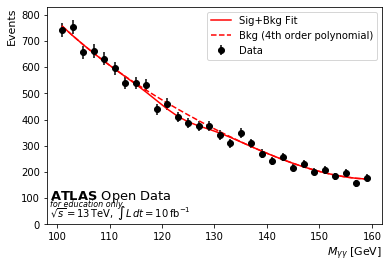

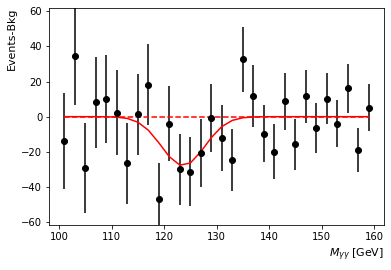

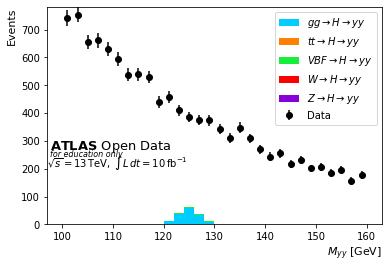

In [13]:
if __name__=="__main__":
    start = time.time()

    cutmin = 0
    cutmax = 1

    for c in range(cutmin,cutmax):
        data = get_data_from_files(c)

    plot_data(data)
    elapsed = time.time() - start
    print("Time taken: "+str(elapsed))
    plot_databar(data)
                      